# Echopype EK60 Cloud Processing

- Creators: Rudy Klucik, Veronica Martinez, Charles Anderson and Carrie Wall
- Affiliations: Cooperative Institute for Research in Environmental Sciences ([CIRES](https://cires.colorado.edu/)) and National Oceanic and Atmospheric Admnistration (NOAA) National Centers for Environmental Information ([NCEI](https://www.ncei.noaa.gov/))
- Acknowledgements: Funding support was provided by the NOAA Center for Artificial Intelligence ([NCAI](https://www.noaa.gov/noaa-center-for-artificial-intelligence/)) and [NOAA Fisheries](https://www.fisheries.noaa.gov/)

## Overview
 Water column sonar data, the acoustic back-scatter from the near-surface to the seafloor, are used to assess physical and biological characteristics of the ocean including the spatial distribution of plankton, fish, methane seeps, and underwater oil plumes. There are a variety of sonar systems including single and multibeam echosounders using single frequency, multiple frequencies, or wideband technology.

 These systems deliver valuable information for ecosystem-based fisheries management but they also produce large data volumes that are costly and complicated to maintain. In collaboration with NOAA Fisheries and CIRES, NCEI archives water columnn sonar data collected from NOAA, academic, and internationals fleets. Archived data are globally accessible through the archive's [data portal](https://www.ncei.noaa.gov/maps/water-column-sonar/) as well as on Amazon Web Services through the NOAA Open Data Dissemintation Project ([NODD](https://www.noaa.gov/information-technology/open-data-dissemination)).

 The native sonar data are large, complex, and recorded in instrument-specific binary file formats. Embedded in the native file's metadata and datagrams are a number of fields including sonar configuration information, navigation information, calibration coefficients and power data from single or multiple sonar frequencies. File names contain the start time for that file, and often include a preceding tag for that cruise or deployment. The timestamp in UTC follows the convention: ‘D’YYYYMMDD’-T’hhmmss. For example, “SaKe2015-D20150719-T193412”, indicates a files from a 2015 SaKe cruise and the start of the file is July 19, 2013 at 19:34:12 (UTC).

The largest volume of raw sonar data in the [NCEI archive](https://www.ncei.noaa.gov/products/water-column-sonar-data) were collected using Simrad EK60 (18-710 kHz, split beam) and EK80 (18-710 kHz, split beam and broadband) echosounders.

This tutorial demonstrates EK60 data processing in the cloud using [echopype](https://echopype.readthedocs.io/en/stable/), an open-source, python-based module for reading, processing, and visualizing water-column echosounder files developed by scientists at the University of Washington.

## Prerequisites
To successfully navigate and use this notebook, you should be familiar with:

- the basics of Python programming such as loading modules assigning variables, and list/array indexing
- plotting data using matplotlib

## Learning Outcomes
By working through this notebook, you will learn how to:

- install echopype
- read a raw EK60 file from an Open Data S3 bucket
- find the calibrated volume backscattering strength (Sv)
- plot data


## Installing and importing libraries

We will first need to install a couple libraries for accessing and processing data.

If you do not already have echopype installed, use the following pip command in the terminal to install it:

> pip install echopype

Note: this notebook uses echopype==0.7.1

If you don't already have boto3 installed, use the following pip command:

> pip install boto3

Libraries can be installed as follows:

In [ ]:
%%capture
!pip install boto3
!pip install botocore
!pip install echopype==0.7.1
!pip install echopype[plot]


Next import the libraries:

In [ ]:
import os
import boto3

import echopype.visualize as epviz
import matplotlib.pyplot as plt
import echopype as ep

#import warnings
#warnings.simplefilter("ignore", category=DeprecationWarning)

In [ ]:
print(f"echopype version: {ep.__version__}")

echopype version: 0.7.1


## Public Data

Publically available data can be accessed from an S3 bucket managed by NOAA's National Centers for Environmental Information. Over 250 TB of data are available for download.


More information on the NOAA Water-Column Sonar Data Archive can be found at the [registry of open data on AWS](https://registry.opendata.aws/ncei-wcsd-archive/)

Files can be easily explored using the [AWS bucket explorer.](https://noaa-wcsd-pds.s3.amazonaws.com/index.html#data/raw/Henry_B._Bigelow/HB0707/EK60/)

The format of the files we will process follow a URL format as follows:

> `https://<Bucket Name>.s3.amazonaws.com/data/raw/<Ship Name>/<Cruise Name>/<Sensor Name>/<File Name>`

For example:

> `https://noaa-wcsd-pds.s3.amazonaws.com/data/raw/Bell_M._Shimada/SH1507/EK60/SaKe2015-D20150719-T193412.raw`

And to learn more about [NCEI's Water Column Sonar Data Archive.](https://www.ncei.noaa.gov/products/water-column-sonar-data)

# Getting started — Reading the Data

First, we will read data from an S3 bucket. The following code reads files passed to it, stores the data in an object, retrieves values from the data, and appends and inserts data from different sampled intervals.

In [ ]:
bucket_name = 'noaa-wcsd-pds'

ship_name = 'Bell_M._Shimada'
cruise_name = 'SH1507'
sensor_name = 'EK60'
file_names = [
  "SaKe2015-D20150719-T193412.raw",
  "SaKe2015-D20150719-T193443.raw",
  "SaKe2015-D20150719-T194042.raw",
  "SaKe2015-D20150719-T194642.raw",
  "SaKe2015-D20150719-T195242.raw",
  "SaKe2015-D20150719-T195842.raw"
]

The next step is to download the raw EK60 files from the S3 public dataset, 'noaa-wcsd-pds.' To do this we will use a library called "boto3." This is a library that gives you access to a full suite of AWS tools, we are just going to use it to download a file from an S3 bucket, and we will do so anonymously using the "UNSIGNED" configuration below.

In [ ]:
from botocore import UNSIGNED
from botocore.client import Config

s3 = boto3.client(service_name='s3', config=Config(signature_version=UNSIGNED))
for file_name in file_names:
  s3.download_file(
      Bucket=bucket_name,
      Key=f'data/raw/{ship_name}/{cruise_name}/{sensor_name}/{file_name}',
      Filename=os.path.basename(file_name),
  )
  print(os.path.basename(file_name))

SaKe2015-D20150719-T193412.raw
SaKe2015-D20150719-T193443.raw
SaKe2015-D20150719-T194042.raw
SaKe2015-D20150719-T194642.raw
SaKe2015-D20150719-T195242.raw
SaKe2015-D20150719-T195842.raw


Next verify that the files were downloaded locally by listing files in the current directory.

In [ ]:
os.listdir()

['.config',
 'SaKe2015-D20150719-T193443.raw',
 'SaKe2015-D20150719-T194042.raw',
 'SaKe2015-D20150719-T195242.raw',
 'SaKe2015-D20150719-T195842.raw',
 'SaKe2015-D20150719-T194642.raw',
 'SaKe2015-D20150719-T193412.raw',
 'sample_data']

## Opening the files with echopype

[Echopype](https://echopype.readthedocs.io/en/stable/index.html) is a python package that enables processing of ocean sonar data. We will use this package to read and process the data files that were downloaded.

In [ ]:
echodata = []
for i in range(len(file_names)):
  print(f"Processing: {file_names[i]}")
  echodata.append(ep.open_raw(raw_file=file_names[i], sonar_model=sensor_name))

Processing: SaKe2015-D20150719-T193412.raw
Processing: SaKe2015-D20150719-T193443.raw
Processing: SaKe2015-D20150719-T194042.raw
Processing: SaKe2015-D20150719-T194642.raw
Processing: SaKe2015-D20150719-T195242.raw
Processing: SaKe2015-D20150719-T195842.raw


We can look at the structure of the data by referencing the first file as follows:

In [ ]:
echodata[0]

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

Echopype organizes the data similar to Xarray's Datasets. Subsets and DataArrays can be accessed via the dot operator, e.g. to access the echodata environment variables you can add ".environment" to the end of the variable.

You will see that an echodata environment variable is composed of:


*   Dimensions
*   Coordinates
*   Data Variables
*   Indexes
*   Attributes

In [ ]:
echodata[0].environment

<xarray.Dataset>
Dimensions:                 (channel: 5, time1: 29)
Coordinates:
  * channel                 (channel) object 'GPT  18 kHz 009072058c8d 1-1 ES...
  * time1                   (time1) datetime64[ns] 2015-07-19T19:34:12.488999...
Data variables:
    absorption_indicative   (channel, time1) float64 0.002822 ... 0.04604
    sound_speed_indicative  (channel, time1) float64 1.481e+03 ... 1.481e+03
    frequency_nominal       (channel) float64 1.8e+04 3.8e+04 ... 1.2e+05 2e+05

Right now our echodata variable is just an array or individually opened echodata objects. Those objects can be combined to form a single echodata object as follows:

In [ ]:
# this code deletes any existing zarr files if you run this notebook more than once
!rm -rf /root/.echopype/temp_output/combined_echodata.zarr

In [ ]:
combined_echodata = ep.combine_echodata(echodata)

/usr/local/lib/python3.10/dist-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 373.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


## Plot the Volume Backscattering Strength, Sv

Echopype has built in methods to easily plot data echodata. To learn more, read the documentation [here](https://echopype.readthedocs.io/en/stable/viz.html).

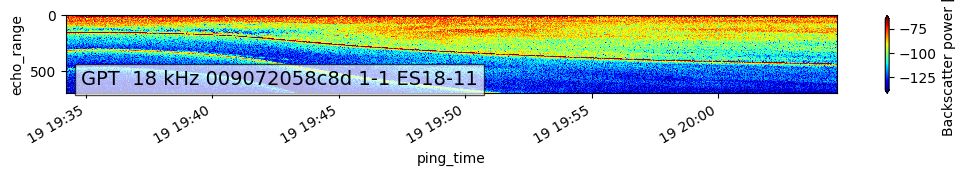

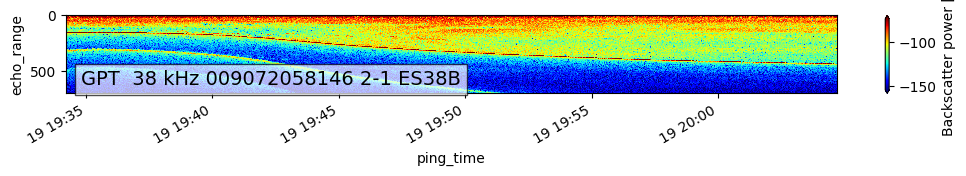

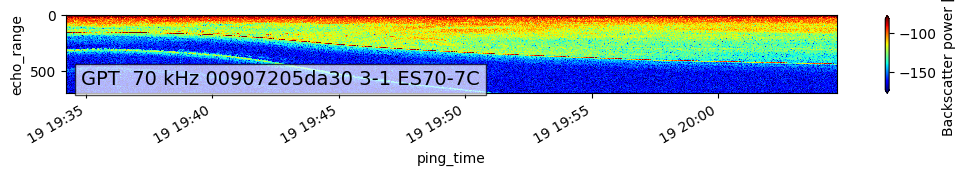

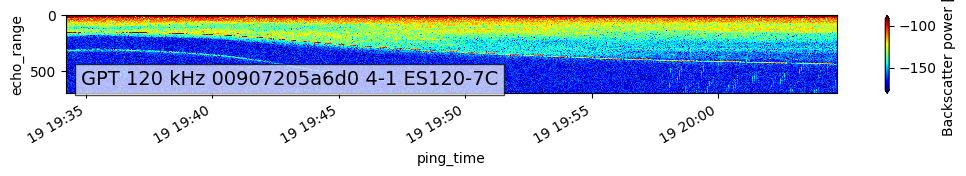

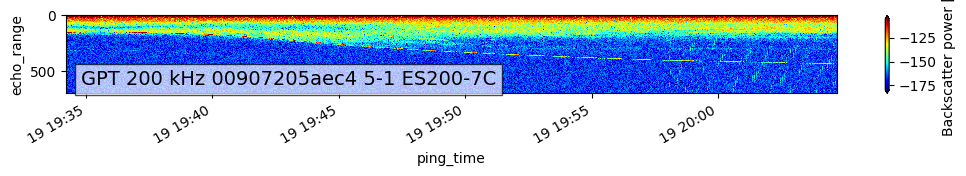

In [ ]:
epviz.create_echogram(combined_echodata, get_range=True, robust=True)

## Calibrate the Data

Volume backscattering strength (Sv) from raw data can be computed as follows:

In [ ]:
ds_Sv = ep.calibrate.compute_Sv(combined_echodata)

In [ ]:
ds_Sv

<xarray.Dataset>
Dimensions:                        (channel: 5, ping_time: 1789,
                                    range_sample: 3694, filenames: 1,
                                    time3: 1789)
Coordinates:
  * channel                        (channel) <U37 'GPT  18 kHz 009072058c8d 1...
  * ping_time                      (ping_time) datetime64[ns] 2015-07-19T19:3...
  * range_sample                   (range_sample) int64 0 1 2 ... 3691 3692 3693
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2015-07-19T19:34:12...
Data variables: (12/16)
    Sv                             (channel, ping_time, range_sample) float64 dask.array<chunksize=(5, 352, 3694), meta=np.ndarray>
    echo_range                     (channel, ping_time, range_sample) float64 dask.array<chunksize=(5, 352, 3694), meta=np.ndarray>
    frequency_nominal              (channel) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    sound_speed                    (channel, ping_time) float64 dask.array<chunksize=(5, 352), meta=np.ndarray>
    sound_absorption               (channel, ping_time) float64 dask.array<chunksize=(5, 352), meta=np.ndarray>
    sa_correction                  (ping_time, channel) float64 dask.array<chunksize=(352, 5), meta=np.ndarray>
    ...                             ...
    angle_sensitivity_alongship    (channel, ping_time) float64 dask.array<chunksize=(5, 352), meta=np.ndarray>
    angle_sensitivity_athwartship  (channel, ping_time) float64 dask.array<chunksize=(5, 352), meta=np.ndarray>
    beamwidth_alongship            (channel, ping_time) float64 dask.array<chunksize=(5, 352), meta=np.ndarray>
    beamwidth_athwartship          (channel, ping_time) float64 dask.array<chunksize=(5, 352), meta=np.ndarray>
    source_filenames               (filenames) <U50 '/root/.echopype/temp_out...
    water_level                    (channel, time3) float64 dask.array<chunksize=(5, 352), meta=np.ndarray>
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.7.1
    processing_time:              2024-03-30T03:47:32Z
    processing_function:          calibrate.compute_Sv

In [ ]:
ds_Sv.coords['channel']

<xarray.DataArray 'channel' (channel: 5)>
array(['GPT  18 kHz 009072058c8d 1-1 ES18-11',
       'GPT  38 kHz 009072058146 2-1 ES38B',
       'GPT  70 kHz 00907205da30 3-1 ES70-7C',
       'GPT 120 kHz 00907205a6d0 4-1 ES120-7C',
       'GPT 200 kHz 00907205aec4 5-1 ES200-7C'], dtype='<U37')
Coordinates:
  * channel  (channel) <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11' ... 'GPT 2...
Attributes:
    long_name:  Vendor channel ID

Because the coordinates of an echopype Dataset are defined by "channel," we can swap the dimensions to organize them by "frequency" instead.

In [ ]:
ds_Sv_freq = ep.consolidate.swap_dims_channel_frequency(ds_Sv)

The updated "ds_Sv_freq" variable now has a coordinate axis defined by the ordinal "frequency_nominal" value versus the previous string-like "channel" as seen in the ds_Sv variable above. This allows data to be subsetted by "frequency" when plotting.

In [ ]:
ds_Sv_freq

<xarray.Dataset>
Dimensions:                        (frequency_nominal: 5, ping_time: 1789,
                                    range_sample: 3694, filenames: 1,
                                    time3: 1789)
Coordinates:
  * ping_time                      (ping_time) datetime64[ns] 2015-07-19T19:3...
  * range_sample                   (range_sample) int64 0 1 2 ... 3691 3692 3693
  * frequency_nominal              (frequency_nominal) float64 1.8e+04 ... 2e+05
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2015-07-19T19:34:12...
Data variables: (12/16)
    channel                        (frequency_nominal) <U37 'GPT  18 kHz 0090...
    Sv                             (frequency_nominal, ping_time, range_sample) float64 dask.array<chunksize=(5, 352, 3694), meta=np.ndarray>
    echo_range                     (frequency_nominal, ping_time, range_sample) float64 dask.array<chunksize=(5, 352, 3694), meta=np.ndarray>
    sound_speed                    (frequency_nominal, ping_time) float64 dask.array<chunksize=(5, 352), meta=np.ndarray>
    sound_absorption               (frequency_nominal, ping_time) float64 dask.array<chunksize=(5, 352), meta=np.ndarray>
    sa_correction                  (ping_time, frequency_nominal) float64 dask.array<chunksize=(352, 5), meta=np.ndarray>
    ...                             ...
    angle_sensitivity_alongship    (frequency_nominal, ping_time) float64 dask.array<chunksize=(5, 352), meta=np.ndarray>
    angle_sensitivity_athwartship  (frequency_nominal, ping_time) float64 dask.array<chunksize=(5, 352), meta=np.ndarray>
    beamwidth_alongship            (frequency_nominal, ping_time) float64 dask.array<chunksize=(5, 352), meta=np.ndarray>
    beamwidth_athwartship          (frequency_nominal, ping_time) float64 dask.array<chunksize=(5, 352), meta=np.ndarray>
    source_filenames               (filenames) <U50 '/root/.echopype/temp_out...
    water_level                    (frequency_nominal, time3) float64 dask.array<chunksize=(5, 352), meta=np.ndarray>
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.7.1
    processing_time:              2024-03-30T03:47:32Z
    processing_function:          calibrate.compute_Sv

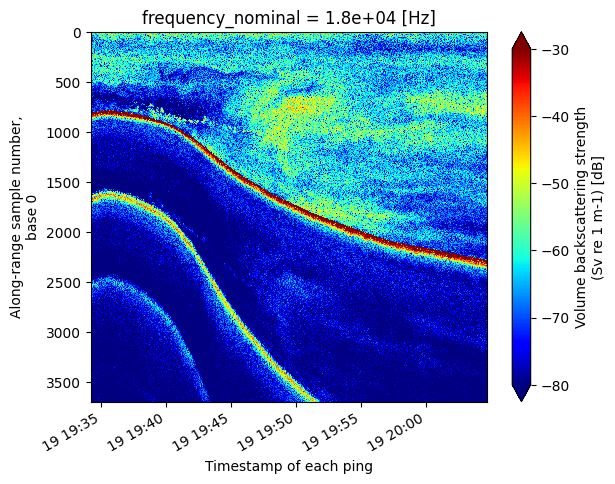

In [ ]:
ds_Sv_freq.Sv.sel(frequency_nominal=18000).plot.pcolormesh(x='ping_time', cmap = 'jet', vmin=-80, vmax=-30, yincrease=False)

The data in the plot above shows a detected bottom at 19:19:35 that starts near 900 meters and tapers to the botom-right down to ~2,200 meters at 19:20:05. Also interesting to note is that beneath the seabed, two harmonics can also be observed which mirror the shape of the ocean floor.

If we would like to further subset the data, we can zoom into the area of interest, here that would entail selecting range_sample(s) between zero and ~2400 meters.

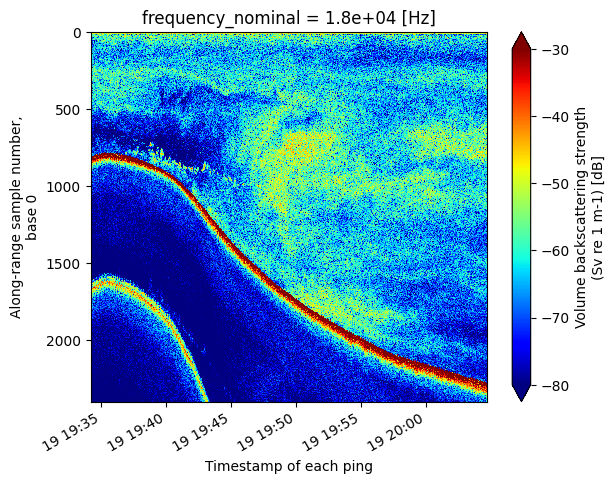

In [ ]:
ds_Sv_freq.Sv.sel(frequency_nominal=18000, range_sample=slice(0, 2400)).plot.pcolormesh(x='ping_time', cmap = 'jet', vmin=-80, vmax=-30, yincrease=False)

The same plot but selecting data from the 38 kHz frequency instead:

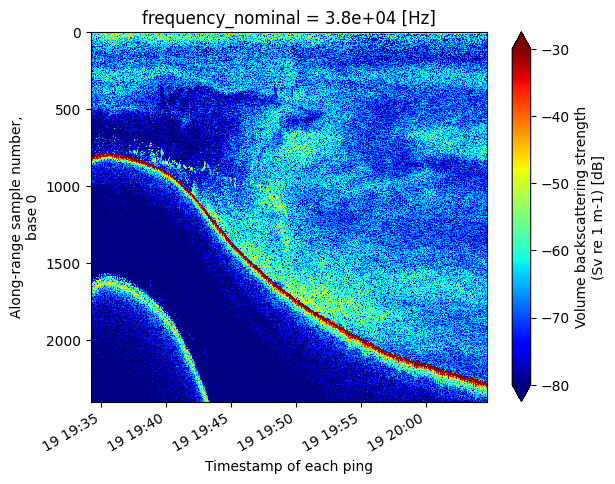

In [ ]:
ds_Sv_freq.Sv.sel(frequency_nominal=38000, range_sample=slice(0, 2400)).plot.pcolormesh(x='ping_time', cmap = 'jet', vmin=-80, vmax=-30, yincrease=False)

And the 70 kHz frequency:

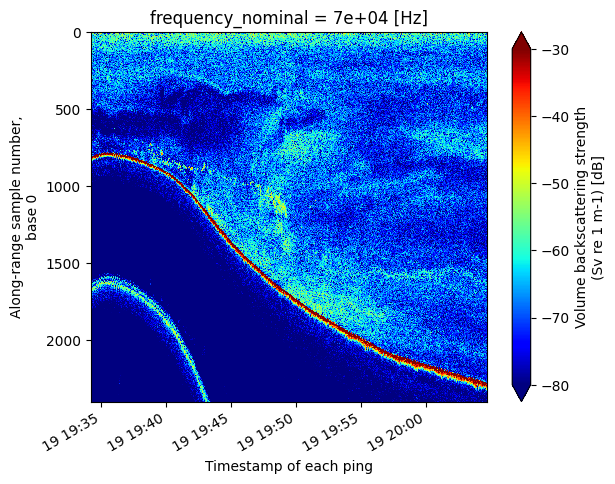

In [ ]:
ds_Sv_freq.Sv.sel(frequency_nominal=70000, range_sample=slice(0, 2400)).plot.pcolormesh(x='ping_time', cmap = 'jet', vmin=-80, vmax=-30, yincrease=False)

The 120 kHz frequency:

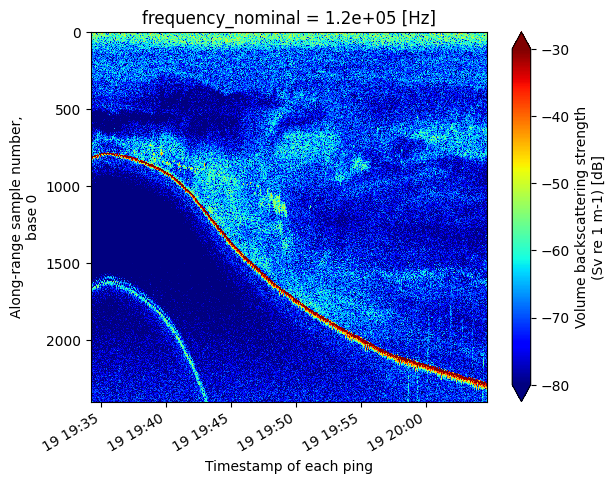

In [ ]:
ds_Sv_freq.Sv.sel(frequency_nominal=120000, range_sample=slice(0, 2400)).plot.pcolormesh(x='ping_time', cmap = 'jet', vmin=-80, vmax=-30, yincrease=False)

And finally the 120 kHz frequency:

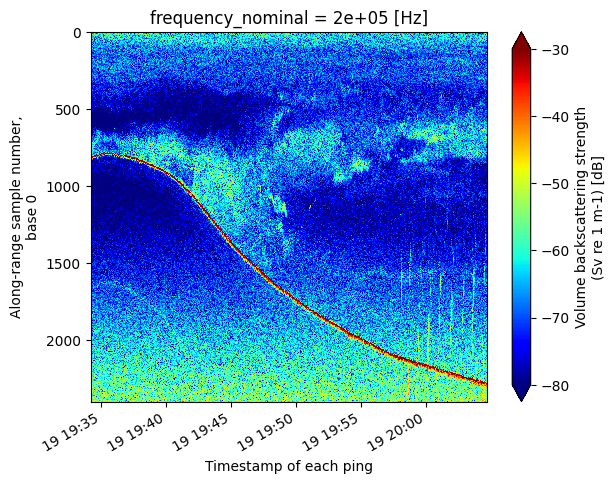

In [ ]:
ds_Sv_freq.Sv.sel(frequency_nominal=200000, range_sample=slice(0, 2400)).plot.pcolormesh(x='ping_time', cmap = 'jet', vmin=-80, vmax=-30, yincrease=False)

Note the change in characteristic of the data with the change in sonar frequency.

By accessing the data using the underlying Xarray Dataset methods, plots can be further configured and allow for diverse subsetting of the data.

# Data statement
All data used in this notebook are publicly available in the [NOAA NCEI Water Column Sonar Data Archive](https://www.ncei.noaa.gov/maps/water-column-sonar/index.html?surveys=SH1507&instruments=EK60)

- A copy can also be found in the archive's [NODD AWS bucket](https://noaa-wcsd-pds.s3.amazonaws.com/index.html#data/raw/Bell_M._Shimada/SH1507/EK60)

# References


*   Lee, W., Mayorga, E., Setiawan, L., Majeed, I., Nguyen, K., & Staneva, V. (2021). Echopype: A Python library for interoperable and scalable processing of water column sonar data for biological information. arXiv preprint arXiv:2111.00187
* Lee, W., Nguyen, K., Setiawan, L., Mayorga, E., Reyes, B., Majeed, I., & Staneva, V. (2023). echopype (v0.8.1). Zenodo. https://doi.org/10.5281/zenodo.8312077
* National Centers for Environmental Information: Water Column Sonar Data Collection. National Centers for Environmental Information, NOAA. http://doi.org/10.7289/V5HT2M7C.



# Metadata
- Language / packages(s):
 - Language: Python
 - Packages: Boto, Echopype, Matplotlib

- Scientific domain:
 - Fisheries acoustics

- Application keywords:
 - Sonar processing

- Geophysical keywords
 - Fish
 - Zooplankton
 - Seafloor

# License
## Software and Content Description License
Software code created by U.S. Government employees is not subject to copyright in the United States (17 U.S.C. §105). The United States/Department of Commerce reserve all rights to seek and obtain copyright protection in countries other than the United States for Software authored in its entirety by the Department of Commerce. To this end, the Department of Commerce hereby grants to Recipient a royalty-free, nonexclusive license to use, copy, and create derivative works of the Software outside of the United States.




# Disclaimer
This Jupyter notebook is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, or the United States Department of Commerce. All NOAA Jupyter notebooks are provided on an 'as is' basis and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.